# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math
import time

In [2]:
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,Genre,Text,Sentiment,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,technical thrash metal|math metal|progressive ...,I originally bought Chaosphere in late 2000......,0.9728,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,grindcore|melodic death metal,A midpoint between Carcass' early grind albums...,0.8479,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,symphonic power metal,"I'm not hard-core into metal at all, really, b...",0.9951,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,heavy metal|us power metal,"This is not a new album, but in fact, five alb...",0.9976,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,power metal,I've been trying for months to come up with an...,0.5494,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...


In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.Graph()
B = nx.Graph()

In [5]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    album = row['Release'] + 'A'
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
            #B[user][genre]['concepts'].add((album,user))
        else:
            B.add_edge(user, genre, weight = 1)
            #B.add_edge(user, genre, weight = 1, concepts = {(album,user)})

In [6]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

[131, 125, 84, 82, 82, 81, 77, 75, 72, 72, 70, 67, 66, 64, 63, 62, 62, 61, 61, 60, 58, 55, 55, 54, 54, 54, 53, 53, 51, 51]


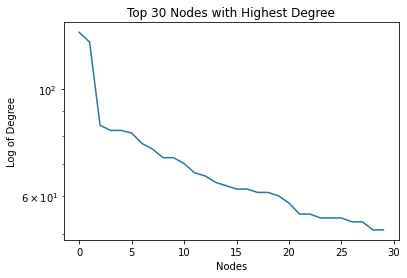

In [7]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[user] for user in users])[-30:]
tmp.reverse()
plt.semilogy(tmp)
print(tmp)
plt.show()

In [8]:
#removing structural holes
remove_users = set()
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        remove_users.add(user)
        users.remove(user)

autothrall
hells_unicorn


In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
                #G[genre1][genre2]['concepts'] = G[genre1][genre2]['concepts'].union(B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))
                #G[genre1][genre2]['users'].add(user)
            else:
                G.add_edge(genre1, genre2, weight = 1)
                #G.add_edge(genre1, genre2, weight = 1, concepts = B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))

In [10]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

In [11]:
#nx.draw(G, node_size = 20)

In [12]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [13]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

In [14]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [15]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

289
190


In [16]:
G3 = G.copy()

In [17]:
K = G3.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
#nx.draw(Core, node_size = 20)

In [18]:
Core.number_of_nodes(),Core.number_of_edges()

(109, 5649)

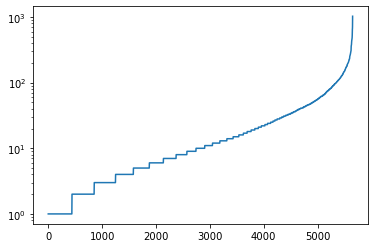

In [19]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))
plt.show()

In [20]:
tmp = sorted(list(nx.get_edge_attributes(Core,'weight').values()))
for i in range(len(tmp)):
    if (tmp[i] == 33):
        print(i)
        break

4450


In [21]:
#plt.hist(sorted(list(nx.get_edge_attributes(Core,'weight').values()))[:5000], log = True)

In [22]:
tmp = sorted([(v,u) for u,v in Core.degree])
#plt.xticks(rotation='')
#plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
#plt.plot([x[0] for x in tmp])
#plt.show()

In [23]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [24]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [25]:
def plotThreshold(Graph, thres):
    J = Graph.copy()
    for u,v in Graph.edges():
        if Graph[u][v]['weight'] < thres: #10 for double counting
            J.remove_edge(u,v)
    J.remove_nodes_from(list(nx.isolates(J)))
    L = J.copy()
    while not no_crossedges(L):
        L = freq_network_parr(L, 10, 4)
    print(thres,nx.number_connected_components(J),nx.number_connected_components(L),J.number_of_nodes())
    comps = nx.connected_components(L)
    part = {}
    for i,comp in enumerate(comps):
        for x in comp:
            part[x] = i
    #return modularity(part,J)
    inter = 0
    intra = 0
    for u,v in J.edges():
        if part[u] == part[v]:
            intra += 1
        else:
            inter += 1
            
    return inter/intra

'''plt.title('Modularity against Weight Threshold')
plt.ylabel('Modularity')
mods = [plotThreshold(Core.copy(), i) for i in range(15,25)]
plt.plot(mods)
plt.show()'''

"plt.title('Modularity against Weight Threshold')\nplt.ylabel('Modularity')\nmods = [plotThreshold(Core.copy(), i) for i in range(15,25)]\nplt.plot(mods)\nplt.show()"

In [26]:
#print(list(enumerate(mods)))

In [27]:
'''#Use modularity and Inter-Intra edges to determine weight threshold
#Use value of 20 (remove any edge below 20)
CoreNew = nx.Graph(Core)
edgeThres = 20
for u,v in Core.edges():
    if Core[u][v]['weight'] < edgeThres:
        CoreNew.remove_edge(u,v)
print(list(nx.isolates(CoreNew)))
CoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))
CoreNew.number_of_nodes(),CoreNew.number_of_edges()
CoreNew = Core
'''

"#Use modularity and Inter-Intra edges to determine weight threshold\n#Use value of 20 (remove any edge below 20)\nCoreNew = nx.Graph(Core)\nedgeThres = 20\nfor u,v in Core.edges():\n    if Core[u][v]['weight'] < edgeThres:\n        CoreNew.remove_edge(u,v)\nprint(list(nx.isolates(CoreNew)))\nCoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))\nCoreNew.number_of_nodes(),CoreNew.number_of_edges()\nCoreNew = Core\n"

In [28]:
#H = G.copy()
H = Core.copy()
#0.9 is good
#H = freq_network_parr(H, 100, 4, res = 0.8)
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

1 5886 5649
1 5886 4029
1 5886 4029
3 2408 2408


In [29]:
partitions = [cc for cc in nx.connected_components(H)]

In [30]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [Core.subgraph(comp) for comp in comps]
    ave_weight = [sum([Core[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([Core[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([Core[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_coeff = [nx.average_clustering(Core, nodes = sub.nodes(), weight = 'weight') for sub in subgraphs]
    ave_coeff = [nx.average_clustering(sub, weight = 'weight') for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev, ave_coeff

In [31]:
[len(cc) for cc in partitions]

[48, 11, 50]

In [32]:
cluster = Core.subgraph(list(nx.connected_components(H))[0])
#nx.draw(cluster, node_size = 100,  font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)
#plt.show()

In [33]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'], ret['Average_Clustering_Coefficient'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{us industrial metal, electro industrial metal...",48,25.234534,24.227837,0.960106,54.810346,0.023615
1,"{industrial grindcore, metalcore, progressive ...",11,112.872727,112.872727,1.000000,165.630701,0.079107
2,"{atmospheric death metal, gothic metal, ambien...",50,22.050707,21.654694,0.982041,29.144492,0.066756


In [34]:
clusters = []
inp = int(input('Enter Cluster ID to Keep: '))
clusters.append(G.subgraph(list(nx.connected_components(H))[inp]))

Enter Cluster ID to Keep:  1


In [35]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = Core.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 4)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        for comp in nx.connected_components(G1):
            clusters.append(Core.subgraph(comp))

In [36]:
inp = 0
tmp = []
inp = input('Enter Cluster IDs for Breakdown: ')
breakDown([int(x) for x in inp.split()])

Enter Cluster IDs for Breakdown:  0 2


1 1128 1083
1 1128 986
1 1128 986
2 561 561
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{us industrial metal, epic doom metal, electro...",27,9.924925,9.415954,0.948718,12.105284,0.114423
1,"{power metal, extreme gothic metal, progressiv...",21,60.908213,60.038095,0.985714,106.320345,0.058792


1 1225 1203
1 1225 848
1 1225 848
4 398 398
End Clustering:  2


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{atmospheric death metal, gothic metal, celtic...",25,19.789831,19.460000,0.983333,23.567499,0.105773
1,"{funeral doom metal, drone doom metal, doom me...",11,35.727273,35.727273,1.000000,55.010893,0.096545
2,"{depressive black metal, shoegaze, post-metal,...",8,38.714286,38.714286,1.000000,30.775520,0.234558
3,"{atmospheric doom metal, melodic doom metal, d...",6,24.000000,24.000000,1.000000,30.086542,0.168902


In [37]:
#nx.write_gpickle(Core,'network_genres.p')

In [38]:
cluster_id = {}
for i,cluster in enumerate(clusters):
    for genre in cluster.nodes():
        cluster_id[genre] = i

In [39]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer() 
def isNaN(x):
    return x != x

def lem(x):
    return ' '.join([lemma.lemmatize(word) for word in x.split()])

In [40]:
t1 = time.time()
all_features = [{} for i in range(len(clusters))]

for i,row in df.iterrows():
    if isNaN(row['Combined_Genre']) or isNaN(row['Product Features_dep']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    if i%5000 == 0:
        print(i,time.time()-t1)
    feature_list = [lem(feature) for feature in row['Product Features_dep'].split('|') if 'metal' not in feature]
    cluster_ids = set([cluster_id[genre] for genre in genre_list if genre in cluster_id])
    for clus in cluster_ids:
        for phrase in feature_list:
            if phrase in all_features[clus]:
                all_features[clus][phrase] += 1
            else:
                all_features[clus][phrase] = 1

0 5.796719551086426
5000 8.4016273021698
20000 11.092374086380005
25000 12.328385829925537
30000 13.427357196807861
35000 14.503211975097656
40000 15.738956212997437
45000 17.032292127609253
50000 18.19629192352295
55000 19.336291551589966
60000 20.451507329940796
65000 21.616686820983887
70000 23.021640300750732
75000 24.47237467765808
85000 27.12190580368042


In [41]:
import pickle

pickle.dump(all_features,open('all_features_by_cluster.p','wb'))

0 0.12560796737670898
10000 1.9832441806793213
20000 3.948692560195923
30000 5.925804853439331
40000 7.983815431594849
50000 10.18417477607727
60000 12.324861764907837
70000 14.488991022109985
80000 16.734569787979126
90000 18.902929306030273


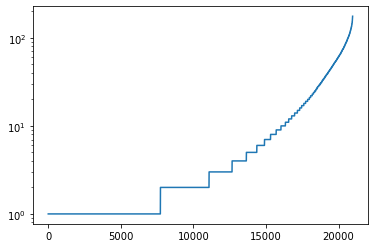

In [43]:
def isNaN(x):
    return x != x

adj_to_genre = {}
t1 = time.time()
all_genres = set()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Product Features_dep'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    for genre in genres.copy():
        if genre not in genre_group or genre_group[genre] == 'Non-metal' or genre_group[genre] == 'Others':
            genres.remove(genre)
    
    for feature in features:
        adj = lemma.lemmatize(feature.split(' ')[0])
        if adj not in adj_to_genre:
            adj_to_genre[adj] = set()
        for genre in genres:
            adj_to_genre[adj].add(genre)
            all_genres.add(genre)

genfreq = {}
for adj in adj_to_genre:
    if len(adj_to_genre[adj]) != 0:
        genfreq[adj] = len(adj_to_genre[adj])

plt.semilogy(sorted(genfreq.values()))
plt.show()    

In [44]:
#cxt is term frequency (tf)
idf = {}
for adj in genfreq:
    idf[adj] = math.log(len(all_genres)/genfreq[adj])

tfidf_list = []

for i, tf in enumerate(all_features):
    tfidf = {}
    for feature in tf:
        adj = feature.split(' ')[0]
        tfidf[feature] = tf[feature]*idf[adj]
    tfidf_list.append(tfidf)

Top 30 features for each cluster
112.87272727272727
['double bass', 'old school', 'swedish band', 'previous album', 'guttural vocal', 'clean vocal', 'sound quality', 'rhythm guitar', 'entire album', 'low end', 'acoustic guitar', '21st century', 'harsh vocal', 'norwegian band', 'catchy riff', 'little bit', 'french band', 'subject matter', 'serial killer', 'lyrical theme', 'brutal band', 'final track', 'bad thing', 'long time', 'female vocal', 'norwegian scene', 'lead guitar', 'black band', 'main riff', 'guttural growl']


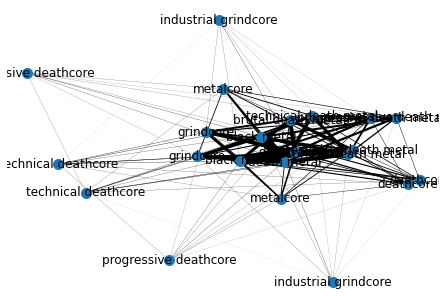


9.924924924924925
['previous album', 'main riff', 'double bass', 'best song', 'live album', '21st century', 'best album', 'hard rock', 'entire album', 'clean vocal', 'tough guy', 'acoustic guitar', 'thrash album', 'late 80', 'rhythm guitar', 'subject matter', 'rhythm section', 'middle section', 'little bit', 'long time', 'thrash riff', 'bad thing', 'lyrical theme', 'catchy riff', 'favorite song', 'fastest song', 'skip button', 'fast riff', 'lead guitar', 'catchy chorus']


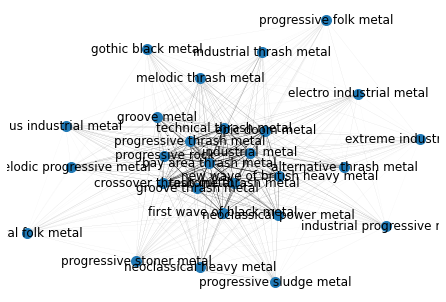


60.908212560386474
['previous album', 'double bass', 'hard rock', 'best song', 'late 80', 'main riff', 'female vocal', 'harsh vocal', 'entire album', 'little bit', 'acoustic guitar', 'subject matter', 'catchy chorus', 'old school', 'rhythm guitar', 'clean vocal', 'rhythm section', 'live album', 'favorite song', '21st century', 'catchy riff', 'bad thing', 'long time', 'best album', 'vocal performance', 'lyrical theme', 'german band', 'blind guardian', 'past year', 'lead guitar']


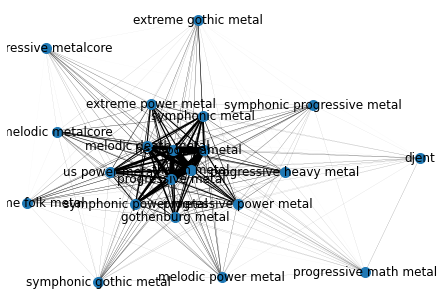


19.789830508474576
['female vocal', 'clean vocal', 'harsh vocal', 'acoustic guitar', 'male vocal', 'double bass', 'previous album', 'avant garde', 'electric guitar', 'entire album', 'gothic band', 'operatic vocal', 'norwegian band', 'female vocalist', 'best song', 'little bit', 'long time', 'bad thing', 'favorite song', 'spoken word', 'lyrical theme', 'final track', 'norse mythology', 'rhythm guitar', 'symphonic element', 'favorite track', 'lead guitar', 'best album', 'subject matter', 'norwegian scene']


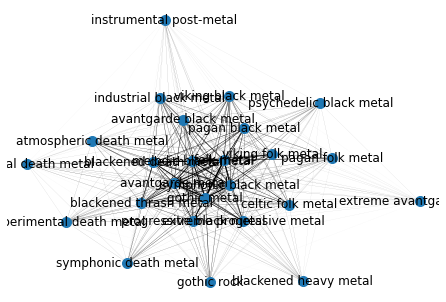


35.72727272727273
['funeral doom', 'female vocal', 'funeral band', 'clean vocal', 'acoustic guitar', 'lead guitar', 'serial killer', 'distorted guitar', 'harsh vocal', 'wounded king', 'subject matter', 'main riff', 'slow riff', 'long time', 'low end', 'heavy riff', 'previous album', 'little bit', 'rhythm guitar', 'sub genre', 'lyrical theme', 'entire album', 'final track', 'southern rock', 'rhythm section', 'sludgy riff', 'favorite track', 'sabbathian riff', 'double bass', 'bad thing']


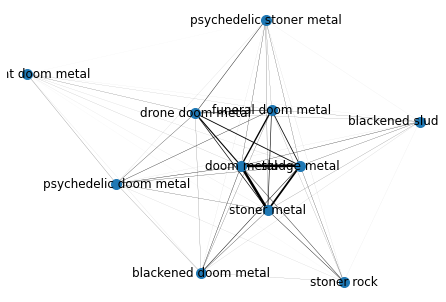


38.714285714285715
['acoustic guitar', 'female vocal', 'clean vocal', 'depressive band', 'harsh vocal', 'distorted guitar', 'electric guitar', 'previous album', 'spoken word', 'ambient music', 'rock influence', 'sub genre', 'ambient track', 'double bass', 'final track', 'subject matter', 'sole member', 'black band', 'entire album', 'neo folk', 'favorite track', 'tortured vocal', 'urban blue', 'american band', 'lead guitar', 'cascadian scene', 'rock band', 'split album', 'bad thing', 'black album']


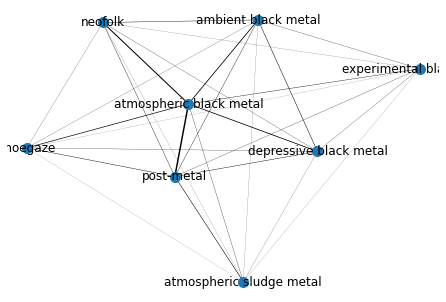


24.0
['female vocal', 'clean vocal', 'discouraged one', 'funeral doom', 'chompy riff', 'harsh vocal', 'southeastern scene', 'male vocal', 'acoustic guitar', 'sassy attitude', 'flippy percussion', 'growled vocal', 'gothic band', 'spoken word', 'spiffy logo', 'finnish band', 'gothic doom', 'female vocalist', 'transylvanian forest', 'lead guitar', 'deep growl', 'previous album', 'rhythm guitar', 'slow riff', 'double bass', 'old school', 'best song', 'ragged vocal', 'guttural vocal', 'distorted guitar']


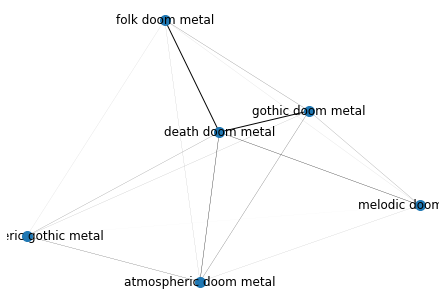

In [46]:
print('Top 30 features for each cluster')
for i,cluster in enumerate(clusters):
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.01)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    mp = {k: v for k, v in sorted(tfidf_list[i].items(), key=lambda item: item[1], reverse = True)}
    print(list(mp.keys())[:30])
    plt.show()
    print()

In [47]:
features_freq = pickle.load(open('opinionsv3.p','rb')) #sorted dictionary of phrases + frequency
print(len(features_freq))
genre_group = pickle.load(open('genre_group.p','rb'))

680777


In [49]:
cxt_raw = []
genres_all = []
features_all = set()
feat_to_gen = {}
t1 = time.time()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    featurelist = [feature for feature in row['Product Features_dep'].split('|') if 'metal' not in feature]
    genrelist = [genre for genre in row['Combined_Genre'].split('|') if genre in genre_group and genre_group[genre] != 'Non-metal' and genre_group[genre] != 'Others']
    for genre in genrelist:
        genre += ' (G)'
        for feature in featurelist:
            #if features_freq[feature] > 1:
            if True:
                feature = lem(feature)
                if feature not in feat_to_gen:
                    feat_to_gen[feature] = set()
                feat_to_gen[feature].add(genre)  
                cxt_raw.append((feature, genre))
                features_all.add(feature)
                genres_all.append(genre)
cxt = clt.Counter(cxt_raw)
genres_all = clt.Counter(genres_all)

0 0.14219999313354492
10000 3.7459487915039062
20000 6.780235290527344
30000 10.758318424224854
40000 15.278717041015625
50000 19.56587052345276
60000 24.207478284835815
70000 28.30270028114319
80000 32.07199692726135
90000 35.83403539657593


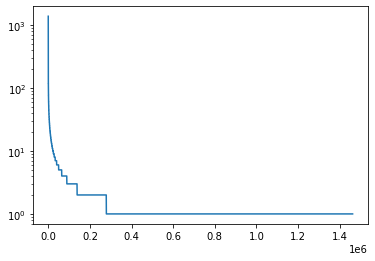

In [50]:
#plt.semilogy(sorted([cxt[(feature,genre)]/genres_all[genre] for feature, genre in cxt_freq], reverse = True))
plt.semilogy(sorted([cxt[(feature,genre)] for feature, genre in cxt], reverse = True))
plt.show()

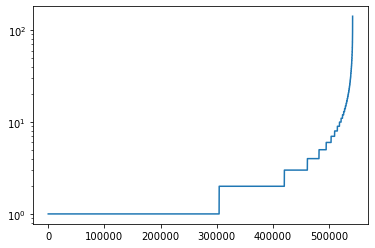

In [51]:
plt.semilogy(sorted([len(feat_to_gen[feature]) for feature in features_all]))
plt.show()

In [52]:
#cxt is term frequency (tf)
idf = {}
for adj in genfreq:
    idf[adj] = math.log(len(all_genres)/genfreq[adj])
tfidf = {}
for feature, genre in cxt:
    adj = feature.split(' ')[0]
    tfidf[(feature,genre)] = cxt[(feature,genre)]*idf[adj]

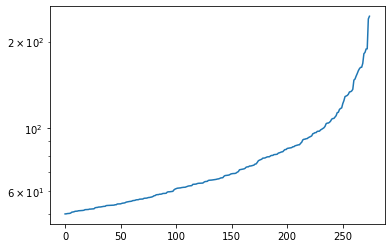

In [53]:
plt.semilogy([x for x in sorted(list(tfidf.values())) if x > 50])
plt.show()

In [54]:
from concepts import Context

In [55]:
thres = 20

genres_final = set(genre for feature, genre in tfidf if tfidf[(feature,genre)] >= thres)
features_final = set(feature for feature, genre in tfidf if tfidf[(feature,genre)] >= thres)
print(len(genres_final), len(features_final))

context_df = pd.DataFrame()
cnt = 0
for genre in genres_final:
    arr = []
    for feature in features_final:
        #if (feature, genre) in cxt and cxt[(feature,genre)]/genres_all[genre] >= 0.05:
        if (feature, genre) in cxt and tfidf[(feature,genre)] >= thres:
            cnt += 1
            arr.append('X')
        else:
            arr.append('')
    context_df[genre] = arr
context_df.index = list(features_final)
context_df.to_csv('fca.csv')
print(cnt)
context_df

38 900
1842


,black metal (G),symphonic power metal (G),atmospheric black metal (G),progressive power metal (G),progressive death metal (G),folk doom metal (G),progressive metal (G),gothenburg metal (G),melodic death metal (G),sludge metal (G),...,symphonic gothic metal (G),depressive black metal (G),viking black metal (G),brutal deathcore (G),heavy metal (G),teutonic thrash metal (G),brutal death metal (G),thrash metal (G),extreme power metal (G),avantgarde metal (G)
fuzzy guitar,X,,,,,,,,,,...,,,,,,,,,,
mid 80,,,,,,,,,,,...,,,,,X,,,X,,
nidrosian scene,X,,,,,,,,,,...,,,,,,,,,,
later album,X,,,,,,,,,,...,,,,,X,,,X,,
depressive act,X,,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
weakest song,,,,,,,,,,,...,,,,,X,,,,,
gruff vocal,,,,,,,,,,,...,,,,,X,,,X,,
chilling atmosphere,X,,,,,,,,,,...,,,,,,,,,,
weak song,,,,,,,,,,,...,,,,,X,,,,,


In [56]:
c = Context.fromfile('fca.csv', frmat = 'csv')
l = c.lattice

In [57]:
f = open('concepts_genres_phrases.txt','w')
for x,y in l:
    f.write(str(x) + '\n\n\n' + str(y) + '\n\n\n.....................\n\n\n')
    f.write('\n')
f.close()

In [58]:
x,y = l[90]
x,y,len(l)

(('fuzzy guitar',
  'distorted guitar',
  'subject matter',
  'double bass',
  'previous album',
  'female vocal',
  'entire album',
  'long time',
  'female vocalist',
  'low end',
  'little bit',
  'rhythm guitar',
  'serial killer',
  'lyrical theme',
  'favorite track',
  'slow riff',
  'acoustic guitar',
  'clean vocal',
  'sub genre',
  'main riff',
  'lead guitar',
  '21st century',
  'heavy riff',
  'operatic vocal',
  'harsh vocal',
  'funeral doom',
  'foulest semen',
  'rhythm section'),
 ('black metal (G)', 'doom metal (G)'),
 128)